In [ ]:
try:
    import google.colab # type: ignore
    from google.colab import output
    COLAB = True
    %pip install sae-lens transformer-lens
except:
    COLAB = False
    from IPython import get_ipython # type: ignore
    ipython = get_ipython(); assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

# Standard imports
import os
import torch
import numpy as np
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import einops
# Imports for displaying vis in Colab / notebook

torch.set_grad_enabled(False)

# For the most part I'll try to import functions and classes near where they are used
# to make it clear where they come from.

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

# utility to clear variables out of the memory & and clearing cuda cache
import gc
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

Device: cuda


In [ ]:
from sae_lens import SAE, HookedSAETransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

BASE_MODEL = "google/gemma-2b"
FINETUNE_MODEL = 'shahdishank/gemma-2b-it-finetune-python-codes'

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

# Load the autoregressive language model
model = AutoModelForCausalLM.from_pretrained(BASE_MODEL)

# RELEASE = 'gemma-2b-res-jb'
# SAE_ID = 'blocks.17.hook_resid_post'

In [ ]:
# base_model = HookedSAETransformer.from_pretrained('gemma-2b', device='cpu', hf_model=model)
base_model = HookedSAETransformer.from_pretrained('gemma-2b', device='cpu')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b into HookedTransformer


In [ ]:
import torch
from torch.nn.functional import cosine_similarity
from enum import Enum
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma

In [ ]:
def get_representations(model, tokenizer, sentence : str, preferred_device : str = None,
                        layer_idx : int = None, names_filter=None) -> torch.Tensor:
    """
    Pass a model, a tokenizer, a sentence, and a device to get the hidden representation of the sentence.

    Args:
    model: A huggingface model.
    tokenizer: A huggingface tokenizer.
    sentence (str): A string.
    preferred_device (str): A string. Default is None.
    layer_idx (int): An integer. Default is None.

    Returns:
    (torch.Tensor) A tensor or a list of tensors (hidden representations).
    """

    if preferred_device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    else:
        device = preferred_device

    # move the model to the device
    if preferred_device == "cuda":
        model.to(device)

    # Tokenize the input sentence and move inputs to GPU if available
    # if tokenizer.pad_token is None:
    #     tokenizer.pad_token = tokenizer.eos_token
    # inputs = tokenizer(sentence, return_tensors='pt', padding=True).to(device)

    # Forward pass through the model
    # outputs = model(sentence, output_hidden_states=True)
    _, cache = model.run_with_cache(sentence, names_filter=names_filter)

    # Return the specific hidden state layer or all hidden states
    # if layer_idx is not None:
    #     return outputs.hidden_states[layer_idx]
    # else:
    #     return outputs.hidden_states
    return cache

In [ ]:
test_sentence = 'we love gemma2'
tokenizer = base_model.tokenizer

representations = get_representations(base_model, tokenizer, test_sentence, layer_idx=None)

In [ ]:
r2 = representations['blocks.2.hook_mlp_out']
r3 = representations['blocks.3.hook_mlp_out']

In [ ]:
# Tommaso's code
class AggregationType(Enum):
    MEAN = 'mean'
    LAST= 'last'

class SimilarityMetric(Enum):
  COSINE = 'cosine'
  EUCLIDEAN = 'euclidean'

import torch
import torch.nn.functional as F

def cosine_metric(matrix1, matrix2):
    # Compute cosine similarity for each pair of vectors along the second dimension
    cosine_similarities = []
    for i in range(matrix1.shape[1]):
        similarity = F.cosine_similarity(matrix1[:, i, :], matrix2[:, i, :], dim=1)
        cosine_similarities.append(similarity)
    return torch.stack(cosine_similarities, dim=1)

def euclidean_distance(matrix1, matrix2):
    # Compute Euclidean distance for each pair of vectors along the second dimension
    distances = []
    for i in range(matrix1.shape[1]):
        distance = torch.norm(matrix1[:, i, :] - matrix2[:, i, :], p=2, dim=1)
        distances.append(distance)
    return torch.stack(distances, dim=1)

def mean_aggregation(tensor):
    return tensor.mean(dim=1)

def last_token_aggregation(tensor):
  return tensor[:, -1, :]

def plot_histogram_with_index(values):
  indices = range(len(values))
  plt.figure(figsize=(24, 6))
  bars = plt.bar(indices, values, tick_label=indices)
  plt.xlabel('Layer')
  plt.ylabel('Similarity')
  plt.title('Similarity of representation through layers')

  for bar in bars:
      height = bar.get_height()
      plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.3f}', ha='center', va='bottom')

  plt.show()

def linear_kernel(X, Y):
  """
  Compute the linear kernel (dot product) between matrices X and Y.
  """
  return torch.mm(X, Y.T)

def HSIC(K, L):
    """
    Calculate the Hilbert-Schmidt Independence Criterion (HSIC) between kernels K and L.
    """
    n = K.shape[0]  # Number of samples
    H = torch.eye(n) - (1./n) * torch.ones((n, n))

    KH = torch.mm(K, H)
    LH = torch.mm(L, H)
    return 1./((n-1)**2) * torch.trace(torch.mm(KH, LH))

def CKA(X, Y):
    """
    Calculate the Centered Kernel Alignment (CKA) for matrices X and Y.
    If no kernel is specified, the linear kernel will be used by default.
    """

    # Compute the kernel matrices for X and Y
    K = linear_kernel(X, X)
    L = linear_kernel(Y, Y)

    # Calculate HSIC values
    hsic = HSIC(K, L)
    varK = torch.sqrt(HSIC(K, K))
    varL = torch.sqrt(HSIC(L, L))

    # Return the CKA value
    return hsic / (varK * varL)



Tensor saved to cosine_similarity_output.pt


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (4, 6).

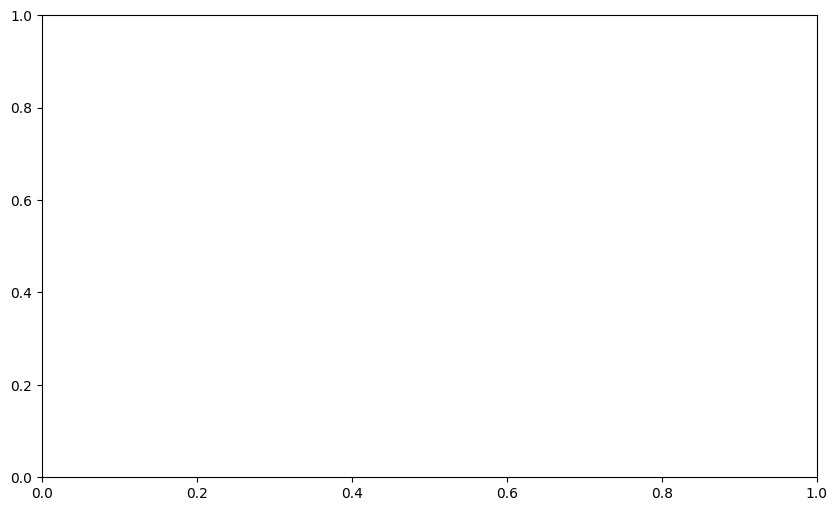

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ChatGPT's code
class SimilarityMetrics:
    def __init__(self, matrix1, matrix2):
        self.matrix1 = matrix1
        self.matrix2 = matrix2
        self.result_tensor = None

    def cosine_metric(self):
        cosine_similarities = []
        for i in range(self.matrix1.shape[1]):
            similarity = F.cosine_similarity(self.matrix1[:, i, :], self.matrix2[:, i, :], dim=1)
            cosine_similarities.append(similarity)
        self.result_tensor = torch.stack(cosine_similarities, dim=1)
        return self.result_tensor

    def euclidean_distance(self):
        distances = []
        for i in range(self.matrix1.shape[1]):
            distance = torch.norm(self.matrix1[:, i, :] - self.matrix2[:, i, :], p=2, dim=1)
            distances.append(distance)
        self.result_tensor = torch.stack(distances, dim=1)
        return self.result_tensor

    def save_tensor(self, file_path="tensor_output.pt"):
        if self.result_tensor is not None:
            torch.save(self.result_tensor, file_path)
            print(f"Tensor saved to {file_path}")
        else:
            print("No result tensor found. Compute similarity or distance first.")

    def save_input_tensors(self, file_name_matrix1="matrix1.pt", file_name_matrix2="matrix2.pt"):
        torch.save(self.matrix1, file_name_matrix1)
        torch.save(self.matrix2, file_name_matrix2)
        print(f"Input tensors saved as {file_name_matrix1} and {file_name_matrix2}")

    def visualize_tensor(self):
        if self.result_tensor is not None:
            # Convert tensor to numpy array for visualization
            result_array = self.result_tensor.squeeze().numpy()

            plt.figure(figsize=(10, 6))
            plt.bar(range(len(result_array)), result_array)
            plt.xlabel('Vector Index')
            plt.ylabel('Similarity/Distance Value')
            plt.title('Similarity/Distance Visualization')
            plt.show()
        else:
            print("No result tensor found. Compute similarity or distance first.")

# Example usage:
# Assuming matrix1 and matrix2 are tensors with shape [1, 6, 2048]
# matrix1 = torch.randn(1, 6, 2048)
# matrix2 = torch.randn(1, 6, 2048)

# Initialize the class
# sim = SimilarityMetrics(matrix1, matrix2)

# Compute cosine similarity or Euclidean distance
# result_cosine = sim.cosine_metric()
# result_euclidean = sim.euclidean_distance()

# Save the result tensor
# sim.save_tensor("cosine_similarity_output.pt")

# Save the input tensors with custom names
# sim.save_input_tensors("custom_matrix1.pt", "custom_matrix2.pt")

# Visualize the result tensor
# sim.visualize_tensor()
